# Import Packages

In [1]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
from gensim import models
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# Sklearn
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer,TfidfTransformer
from sklearn.decomposition import NMF

# NLTK
import nltk
nltk.download('wordnet')
from nltk.corpus import wordnet as wn
from nltk.stem.wordnet import WordNetLemmatizer

# spacy for lemmatization
import spacy
from spacy.lang.en import English
parser = English()

# Kafka for data streamming
from kafka import KafkaProducer

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline



import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

C:\Users\billis\Anaconda3\Lib\site-packages\gensim\utils.py:1209: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\billis\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
stopWordsDictionary = {lang: set(nltk.corpus.stopwords.words(lang)) for lang in nltk.corpus.stopwords.fileids()}

# Read JSON

In [3]:
# Read function
def getJSON(path):
    """
    Read dataset

    Parameters:
    ----------
    path : String that includes tha path the dataset resides

    Returns:
    -------
    data_df : Parsed JSON (Dataframe)
    """
    data_df = pd.read_json(path, lines = True)
    print(data_df.count())
    return data_df

In [4]:
jsonFileTweetsDF = getJSON('./data/IG-comments.txt') # Read entities serialized file

# Rename columns
jsonFileTweetsDF.rename(columns={'id': 'comment_id'}, inplace=True)

# Print column information
print(jsonFileTweetsDF.columns)

created_time    46483
from            46483
id              46483
text            46483
dtype: int64
Index(['created_time', 'from', 'comment_id', 'text'], dtype='object')


# Pre-processing

In [245]:
jsonFileTweetsDF.dropna(inplace = True) # Drop records with empty values
jsonFileTweetsDF.head(100) # Eplore the data

,created_time,from,comment_id,text
0,2017-10-25 14:10:40,"{'id': '1705851671', 'username': 'harseeyah', ...",17903568079032160,well am not the coffee lover but thanks to som...
1,2017-10-25 12:29:46,"{'id': '2232789447', 'username': 'daniyel.07.0...",17888404102085460,@molds99 ахахаах
2,2017-10-25 12:15:50,"{'id': '1624610960', 'username': 'molds99', 'p...",17901122062065144,@daniyel.07.03 пошел нахуй
3,2017-10-25 12:05:20,"{'id': '2232789447', 'username': 'daniyel.07.0...",17892526528103870,@molds99
4,2017-10-25 08:41:06,"{'id': '2090245069', 'username': 'rubenooft', ...",17904262369037238,I love this new idea! I ordered something last...
5,2017-10-25 06:04:23,"{'id': '5960679581', 'username': 'rickymooreda...",17904673342051288,*waving* :)
6,2017-10-25 05:52:05,"{'id': '1416537070', 'username': 'mrjellysamic...",17904753625016616,SZECHUAN SAUCE
7,2017-10-25 05:19:05,"{'id': '1575251581', 'username': 'dicey.bmx', ...",17904207205024306,Why are you gonna get rid of every shake flavo...
9,2017-10-25 04:33:58,"{'id': '363450410', 'username': 'moni0388', 'p...",17892065179101564,Yummy
10,2017-10-25 02:06:09,"{'id': '2417970810', 'username': 'brid.gette_s...",17891883385106240,Sorry I stole ur tissue.


In [6]:
def get_language(text):
    """
    Language detection

    Parameters:
    ----------
    text : List with the respected comments
    
    Returns:
    -------
    lang : String with the identified language

    """
    if type(text) is str:
        text = text.lower()
    words = set(nltk.wordpunct_tokenize(text))
    return max(((lang, len(words & stopwords)) for lang, stopwords in stopWordsDictionary.items()), key = lambda x: x[1])[0]

# Data pre-processing

In [7]:
def remove_emoji(string):
    """
    Emojis removal (The standard way of removing emojis did not capture all the unicodes)

    Parameters:
    ----------
    string : Single line of text.

    Returns:
    -------
    string : Single cleaned line of text.
 
    """
    emoji_pattern = re.compile("["
                       u"\U0001F600-\U0001F64F"  # emoticons
                       u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                       u"\U0001F680-\U0001F6FF"  # transport & map symbols
                       u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                       u"\U00002702-\U000027B0"
                       u"\U000024C2-\U0001F251"
                       u"\U0001f926-\U0001f937"
                       u"\u200d"
                       u"\u2640-\u2642" 
                       "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)

In [8]:
jsonFileTweetsDF['text'] = jsonFileTweetsDF.text.apply(remove_emoji) # Remove Emojis
jsonFileTweetsDF['text'].replace('', np.nan, inplace=True)
jsonFileTweetsDF.dropna( subset = ['text'], axis = 0,inplace = True)

In [9]:
jsonFileTweetsDF.count()

created_time    44716
from            44716
comment_id      44716
text            44716
dtype: int64

In [10]:
def tokenize(text):
    """
    Tokenization using Spacy

    Parameters:
    ----------
    text : List of strings

    Returns:
    -------
    lda_tokens : List of tokens

    """
    lda_tokens = []
    tokens = parser(text)
    for token in tokens:
        if token.orth_.isspace():
            continue       
        if token.is_punct:
            continue
        if token.is_digit:
            continue
        elif token.like_url:
            continue
            #lda_tokens.append('URL')
        elif token.orth_.startswith('@'):
            continue
            #lda_tokens.append('SCREEN_NAME')
        else:
            lda_tokens.append(token.lower_)  
        
    return lda_tokens

In [11]:
def get_lemma(word):
    """
    Lemmatization

    Parameters:
    ----------
    word : Single token

    Returns:
    -------
    word  : Same word in case the lemma does not exist
    lemma : Lemma
  
    """
    lemma = wn.morphy(word)
    if lemma is None:
        return word
    else:
        return lemma
    

def get_lemma2(word):
    return WordNetLemmatizer().lemmatize(word)

In [12]:
nltk.download('stopwords')
en_stop = set(nltk.corpus.stopwords.words('english'))
nonEnglishStopWords = set(nltk.corpus.stopwords.words()) - en_stop

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\billis\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [13]:
def prepare_text_for_lda(text):
    """
    Prepare text for consuming

    Parameters:
    ----------
    text : List of texts

    Returns:
    -------
    tokens  : List of extracted tokens 
    """
    tokens = tokenize(text)
    tokens = [token for token in tokens if len(token) > 4]
    tokens = [token for token in tokens if token not in en_stop]
    tokens = [token for token in tokens if token not in nonEnglishStopWords]
    tokens = [get_lemma2(token) for token in tokens]
    return tokens

In [34]:
text_data = []
texts = jsonFileTweetsDF.text.apply(prepare_text_for_lda)
tokens_without_empty_lists = [e for e in texts if e]
# remove words that appear only once
tokens = sum(tokens_without_empty_lists, [])
tokens_once = set(word for word in set(tokens) if tokens.count(word) == 1)
tokens = [[word for word in text if word not in tokens_once] for text in tokens_without_empty_lists]
tokens = [e for e in tokens if e]
#text_data.append(tokens)

# Topic Modelling v1

## Bag-of-words 

In [43]:
from gensim import corpora
id2word = corpora.Dictionary(tokens)
corpus = [id2word.doc2bow(text) for text in tokens]

## Training

In [44]:
# Model optimization
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values_lda = []
    coherence_values_lsi = []
    model_list_lda = []
    model_list_lsi = []
    for num_topics in range(start, limit, step):
        # LDA training
        model_lda = lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=50,
                                           alpha='auto',
                                           per_word_topics=True)
        # LSI training
        model_lsi = gensim.models.LsiModel(corpus=corpus, 
                                          num_topics=num_topics, 
                                          id2word=id2word,                                          
                                          chunksize=100)
        
        
        
        model_list_lda.append(model_lda)
        coherencemodel_lda = CoherenceModel(model=model_lda, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values_lda.append(coherencemodel_lda.get_coherence())
        
        model_list_lsi.append(model_lsi)
        coherencemodel_lsi = CoherenceModel(model=model_lsi, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values_lsi.append(coherencemodel_lsi.get_coherence())

    return model_list_lda, coherence_values_lda, model_list_lsi, coherence_values_lsi

In [45]:

model_list_lda, coherence_values_lda,model_list_lsi,coherence_values_lsi = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=tokens, start=2, limit=50, step=4)

## Performance Visualization

In [46]:
# Show graph
def coherence_viz(coherence_values,title, limit, start, step):
    """
    Performance visualization

    Parameters:
    ----------
    coherence_values : List of coherence values
    title : The title of the model
    limit : Upper topic limit 
    start : Minimum number of topics
    step  : Step
    
    Returns:
    -------
  
    """
    x = range(start, limit, step)
    plt.plot(x, coherence_values)
    plt.title(title)
    plt.xlabel("Num Topics")
    plt.ylabel("Coherence score")
    plt.legend(("coherence_values"), loc='best')
    plt.show()

In [47]:
# Print the coherence scores
def print_scores(coherence_values, model_name, limit, start, step):
    """
    Print scores in single lines

    Parameters:
    ----------
    coherence_values : List of coherence values
    title : The title of the model
    limit : Upper topic limit 
    start : Minimum number of topics
    step  : Step
    
    Returns:
    -------
  
    """
    x = range(start, limit, step)
    print (model_name)
    for m, cv in zip(x, coherence_values):
        print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

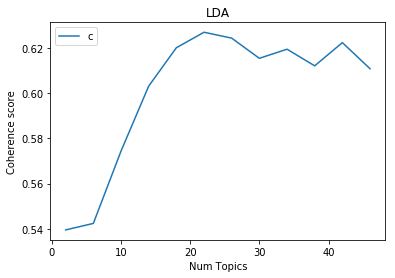

In [49]:
coherence_viz(coherence_values_lda,'LDA', 50,2,4)

In [50]:
print_scores(coherence_values_lda,'LDA', 50,2,4)

LDA
Num Topics = 2  has Coherence Value of 0.5396
Num Topics = 6  has Coherence Value of 0.5424
Num Topics = 10  has Coherence Value of 0.5744
Num Topics = 14  has Coherence Value of 0.6031
Num Topics = 18  has Coherence Value of 0.62
Num Topics = 22  has Coherence Value of 0.6268
Num Topics = 26  has Coherence Value of 0.6243
Num Topics = 30  has Coherence Value of 0.6153
Num Topics = 34  has Coherence Value of 0.6194
Num Topics = 38  has Coherence Value of 0.612
Num Topics = 42  has Coherence Value of 0.6223
Num Topics = 46  has Coherence Value of 0.6107


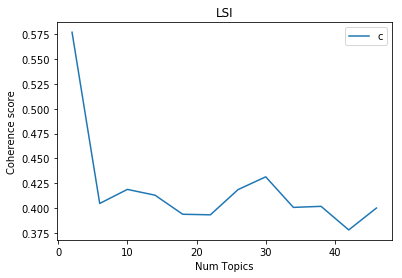

In [51]:
coherence_viz(coherence_values_lsi,'LSI', 50,2,4)

In [52]:
print_scores(coherence_values_lsi,'LSI', 50,2,4)

LSI
Num Topics = 2  has Coherence Value of 0.5772
Num Topics = 6  has Coherence Value of 0.4046
Num Topics = 10  has Coherence Value of 0.4187
Num Topics = 14  has Coherence Value of 0.4129
Num Topics = 18  has Coherence Value of 0.3937
Num Topics = 22  has Coherence Value of 0.3931
Num Topics = 26  has Coherence Value of 0.4185
Num Topics = 30  has Coherence Value of 0.4314
Num Topics = 34  has Coherence Value of 0.4006
Num Topics = 38  has Coherence Value of 0.4017
Num Topics = 42  has Coherence Value of 0.3779
Num Topics = 46  has Coherence Value of 0.3999


# Results

## LDA Model

In [53]:
# Select the model and print the topics
optimal_model = model_list_lda[5]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.066*"hahaha" + 0.050*"amazing" + 0.050*"craving" + 0.049*"america" + '
  '0.039*"video" + 0.036*"caption" + 0.032*"block" + 0.031*"ronald" + '
  '0.024*"buena" + 0.021*"essen"'),
 (2,
  '0.218*"diabetes" + 0.052*"mmmmm" + 0.052*"thanks" + 0.035*"pretty" + '
  '0.030*"question" + 0.028*"food" + 0.026*"goal" + 0.024*"death" + '
  '0.022*"preservative" + 0.018*"obesity"'),
 (3,
  '0.084*"mcgriddle" + 0.040*"first" + 0.039*"model" + 0.034*"minute" + '
  '0.029*"apple" + 0.026*"garbage" + 0.025*"mmmmmm" + 0.025*"served" + '
  '0.024*"drink" + 0.021*"small"'),
 (21,
  '0.246*"please" + 0.171*"hungry" + 0.037*"share" + 0.023*"delete" + '
  '0.021*"follower" + 0.020*"contact" + 0.019*"choose" + 0.018*"quality" + '
  '0.016*"jalapeño" + 0.015*"roast"'),
 (15,
  '0.092*"world" + 0.075*"comment" + 0.044*"someone" + 0.040*"unhealthy" + '
  '0.040*"quiero" + 0.033*"year" + 0.027*"artificial" + 0.025*"hamburguesa" + '
  '0.024*"disease" + 0.021*"another"'),
 (8,
  '0.066*"donalds" + 0.035*

In [55]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(optimal_model, corpus, id2word)
vis

C:\Users\billis\Anaconda3\Lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6     -0.424656 -0.145684       1        1  14.387272
10     0.080150 -0.175024       2        1  12.657645
20     0.065403 -0.121304       3        1   6.685868
17     0.016129 -0.069886       4        1   5.415061
11    -0.083943  0.256512       5        1   4.528194
16     0.010079 -0.063976       6        1   4.237478
19    -0.046530  0.112375       7        1   4.224916
7      0.083484 -0.096106       8        1   3.836530
12     0.018184  0.005266       9        1   3.657099
18     0.037156 -0.008326      10        1   3.575955
1      0.007158  0.039337      11        1   3.458453
9      0.058725 -0.027456      12        1   3.425611
4      0.000111  0.033104      13        1   3.391768
13     0.045633 -0.014954      14        1   3.260174
14     0.039458 -0.001190      15        1   3.209695
5      0.014968  0.042237      16        1   3.155451
8      0.040666 -0.004252      17        1   3.102936
15     0.027345  0.014756      18        1   2.974743
21     0.010145  0.022838      19        1   2.907970
3      0.025127  0.024509      20        1   2.795968
2     -0.027258  0.108497      21        1   2.665020
0      0.002467  0.068725      22        1   2.446189, topic_info=     Category         Freq         Term        Total  loglift  logprob
term                                                                  
69    Default  1219.000000     mcdonald  1219.000000  30.0000  30.0000
479   Default   747.000000       burger   747.000000  29.0000  29.0000
66    Default   742.000000    mcdonalds   742.000000  28.0000  28.0000
19    Default   637.000000      chicken   637.000000  27.0000  27.0000
18    Default   566.000000        bring   566.000000  26.0000  26.0000
7     Default   841.000000        sauce   841.000000  25.0000  25.0000
22    Default   480.000000       please   480.000000  24.0000  24.0000
256   Default   820.000000          fry   820.000000  23.0000  23.0000
468   Default   507.000000         look   507.000000  22.0000  22.0000
212   Default   388.000000     diabetes   388.000000  21.0000  21.0000
220   Default   627.000000       nugget   627.000000  20.0000  20.0000
82    Default   333.000000       hungry   333.000000  19.0000  19.0000
338   Default   342.000000        would   342.000000  18.0000  18.0000
49    Default   393.000000       eating   393.000000  17.0000  17.0000
101   Default   319.000000       follow   319.000000  16.0000  16.0000
74    Default   298.000000       really   298.000000  15.0000  15.0000
36    Default   299.000000       better   299.000000  14.0000  14.0000
357   Default   295.000000       cheese   295.000000  13.0000  13.0000
8     Default   420.000000     szechuan   420.000000  12.0000  12.0000
356   Default   313.000000      machine   313.000000  11.0000  11.0000
292   Default   285.000000        right   285.000000  10.0000  10.0000
309   Default   241.000000   disgusting   241.000000   9.0000   9.0000
937   Default   252.000000    breakfast   252.000000   8.0000   8.0000
14    Default   239.000000        yummy   239.000000   7.0000   7.0000
50    Default   272.000000        happy   272.000000   6.0000   6.0000
0     Default   211.000000       coffee   211.000000   5.0000   5.0000
358   Default   240.000000     favorite   240.000000   4.0000   4.0000
206   Default   202.000000       cancer   202.000000   3.0000   3.0000
580   Default   209.000000       number   209.000000   2.0000   2.0000
125   Default   347.000000        never   347.000000   1.0000   1.0000
...       ...          ...          ...          ...      ...      ...
1938  Topic22    81.767456      craving    82.833992   3.6977  -2.9958
620   Topic22    80.923409      america    81.989944   3.6975  -3.0062
863   Topic22    64.066727        video    65.133263   3.6941  -3.2398
1594  Topic22    58.244682      caption    59.311222   3.6925  -3.3351
1666  Topic22    52.943974        

# Topic Modeling v2

## NMF

In [56]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx , topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx))
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words -1:-1]]))

In [57]:
data = [' '.join(text) for text in tokens]

In [58]:
no_features = 1000
# NMF is able to use tf-idf
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, max_features=no_features, stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(data)
tfidf_feature_names = tfidf_vectorizer.get_feature_names()

In [59]:
no_topic = 20
no_top_words = 10
nmf = NMF(n_components=no_topic, random_state = 42, alpha =.1, l1_ratio=.5, init = 'nndsvd').fit(tfidf)
display_topics(nmf ,tfidf_feature_names, no_top_words)

Topic 0:
szechuan sauce sause better wheres dipping teriyaki suace need gimme
Topic 1:
bring orange mulan grand mcrib mcvegan szechuansauce stick selects szechaun
Topic 2:
machine broke broken working icecream work sorry fixed probably mcflurry
Topic 3:
follow mcdonnol account beautiful photo meme instagram insta support maccas
Topic 4:
mcdonald going people eating today ronald really boycott thing trying
Topic 5:
sauce mulan dipping morty szechaun mcnugget sezchuan teriyaki season sezuchan
Topic 6:
mcdonalds eating suck thing boycott going today really people breakfast
Topic 7:
burger better cheese vegan veggie nutella looked really wendy mcvegan
Topic 8:
nugget piece scared need plastic better thing favorite taste chicken
Topic 9:
fry french thing large better salty curly drink great vegan
Topic 10:
right eating order getting hungry totally single thing really going
Topic 11:
cream machine vanilla broken working serve hentai chocolate today fixed
Topic 12:
sponsor kidding film family

## Save Models

In [137]:
# Save model to disk.
optimal_model.save('models/pre_process_BoW/lda_optimal.model')

# Topic assign

In [249]:
model =  models.LdaModel.load('models/pre_process_BoW/lda_optimal.model') # Load the model


In [171]:
# Find and assign the dominant topic for each comment.
def format_topics_sentences(ldamodel, corpus, texts):
    """
    Model optimization

    Parameters:
    ----------
    ldamodel : List of coherence values
    corpus : Text corpus
    texts : Raw texts or tokens 
    
    Returns:
    -------
    sent_topics_df : Dataframe with the dominant topic, the percentage of contribution and the topic keywords'
    
    """
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row[0], key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output', '.join(mylist)
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

In [172]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=model, corpus=corpus, texts=tokens)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,6.0,0.1264,"fry, nugget, never, today, could, always, peop...","[coffee, lover, thanks, someone, mccafe]"
1,1,6.0,0.1362,"fry, nugget, never, today, could, always, peop...","[ordered, something]"
2,2,10.0,0.1734,"sauce, szechuan, actually, looked, telolet, sa...","[szechuan, sauce]"
3,3,6.0,0.1264,"fry, nugget, never, today, could, always, peop...","[every, shake, flavor, besides, vanilla]"
4,4,6.0,0.1398,"fry, nugget, never, today, could, always, peop...",[yummy]
5,5,6.0,0.1342,"fry, nugget, never, today, could, always, peop...","[sorry, stole, tissue]"
6,6,6.0,0.1238,"fry, nugget, never, today, could, always, peop...","[please, bring, chicken, sandwich, orange, cou..."
7,7,10.0,0.1691,"sauce, szechuan, actually, looked, telolet, sa...","[szechuan, sauce, spell]"
8,8,6.0,0.1327,"fry, nugget, never, today, could, always, peop...","[cream, sugar, please]"
9,9,6.0,0.1362,"fry, nugget, never, today, could, always, peop...","[bring, holiday]"


In [64]:
# Group top 5 sentences under each topic
sent_topics_sorteddf = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf = pd.concat([sent_topics_sorteddf, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf.head()

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.2475,"hahaha, amazing, craving, america, video, capt...","[bonnes, condition, souvent, donner, meilleur,..."
1,1.0,0.1527,"mcdonalds, cancer, y'all, comida, holiday, ins...","[really, mcdonalds, signature, crafted, artisa..."
2,2.0,0.2955,"diabetes, mmmmm, thanks, pretty, question, foo...","[mostly, chicken, percent, chicken, difference..."
3,3.0,0.3369,"mcgriddle, first, model, minute, apple, garbag...","[bubba, anyway, sayin, shrimp, fruit, barbecue..."
4,4.0,0.1216,"burger, delicious, think, bigmac, white, weird...","[mcdonald, contain, acrylamide, realize, tryin..."


In [109]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics.head(10)

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0,6.0,"fry, nugget, never, today, could, always, peop...",1.0,0.0000
1,6.0,"fry, nugget, never, today, could, always, peop...",2.0,0.0001
2,10.0,"sauce, szechuan, actually, looked, telolet, sa...",8.0,0.0003
3,6.0,"fry, nugget, never, today, could, always, peop...",4.0,0.0002
4,6.0,"fry, nugget, never, today, could, always, peop...",1.0,0.0000
5,6.0,"fry, nugget, never, today, could, always, peop...",11.0,0.0004
6,6.0,"fry, nugget, never, today, could, always, peop...",20427.0,0.7830
7,10.0,"sauce, szechuan, actually, looked, telolet, sa...",4.0,0.0002
8,6.0,"fry, nugget, never, today, could, always, peop...",8.0,0.0003
9,6.0,"fry, nugget, never, today, could, always, peop...",5.0,0.0002


In [62]:
df_dominant_topic['Dominant_Topic'].unique()

array([ 6., 10., 20., 21.,  5., 15., 11., 14., 13., 19., 18., 17.,  9.,
       12., 16.,  8.,  7.,  3.,  2.,  1.,  4.,  0.])

# Connect to Kafka (The code of this section was not used eventually)

In [108]:
# Create producer
def connect_kafka_producer():
    _producer = None
    try:
        _producer = KafkaProducer(bootstrap_servers=['localhost:9092'], api_version=(0, 10))
    except Exception as ex:
        print('Exception while connecting Kafka')
        print(str(ex))
    finally:
        return _producer

In [118]:
# Publish messages to Kafka
def publish_message(producer_instance, topic_name, key, value):
    try:
        key_bytes = bytes(key, encoding='utf-8')
        value_bytes = bytes(value, encoding='utf-8')
        producer_instance.send(topic_name, key=key_bytes, value=value_bytes)
        producer_instance.flush()
        print('Message published successfully.')
    except Exception as ex:
        print('Exception in publishing message')
        print(str(ex))

In [133]:
print('Publishing records to Kafka..')
topic_name = 'kafka-logs'
producer = connect_kafka_producer()

publish_message(producer, topic_name, 'parsed', df)


Publishing records..
Message published successfully.


# Import data to Elastic Search

In [136]:
df_dominant_topic.to_csv('final.csv', sep=',', encoding='utf-8') # Save the dominant topic 

In [251]:
import csv
from collections import deque
import elasticsearch
from elasticsearch import helpers

def readCSV():
    csvfile = open('final.csv', 'r',encoding='utf-8')

    #titleLookup = readMovies()

    reader = csv.DictReader( csvfile )
    for line in reader:
        rating = {}
        rating['Dominant_Topic'] = float(line['Dominant_Topic'])
        rating['Text'] = line['Text'].strip("[]")#str(line['Text'])
        yield rating 

In [262]:
from elasticsearch import Elasticsearch
host = '127.0.0.1:9200'
elastic_con = Elasticsearch([host], verify_certs=True)
mapping = '''
{  
  "mappings":{  
    "mc_comment_v1":{  
      "properties":{  
        "Dominant_Topic":{ "type" : "float"},
        "Text" : {"type" : "text", "analyzer" : "english"}
      }
    }
  }
}'''
elastic_con.indices.create(index='mc_comments_v1', ignore=400, body=mapping)

{'acknowledged': True, 'shards_acknowledged': True, 'index': 'mc_comments_v1'}

In [263]:
es = elasticsearch.Elasticsearch() # Create Elasticsearch object
es.indices.delete(index="mc_comments_v1",ignore=404) # Delete indices if exist
deque(helpers.parallel_bulk(es,readCSV(),index="mc_comments_v1",doc_type="mc_comment_v1"), maxlen=0) # Create index and import data
es.indices.refresh() # Refresh the index list

{'_shards': {'total': 21, 'successful': 11, 'failed': 0}}

In [264]:
# Query Elasticsearch for similar comments and classify them according to the retreived score and label.
es.search(index='mc_comments_v1', body = {'query': {
    "more_like_this" : {
        "fields" : ['Text'],
        "like" : ['well am not the coffee lover but thanks to someone i love it.. will love to try it soon #mcCafe @boldleonidas']
        }
    }
})

{'took': 6,
 'timed_out': False,
 '_shards': {'total': 5, 'successful': 5, 'skipped': 0, 'failed': 0},
 'hits': {'total': 5,
  'max_score': 9.136661,
  'hits': [{'_index': 'mc_comments_v1',
    '_type': 'mc_comment_v1',
    '_id': 'mi1kO2cBx770HfuOKrIt',
    '_score': 9.136661,
    '_source': {'Dominant_Topic': 6.0, 'Text': "'love'"}},
   {'_index': 'mc_comments_v1',
    '_type': 'mc_comment_v1',
    '_id': 'Sy1kO2cBx770HfuOIIYR',
    '_score': 7.5345016,
    '_source': {'Dominant_Topic': 6.0, 'Text': "'mcdonald', 'love'"}},
   {'_index': 'mc_comments_v1',
    '_type': 'mc_comment_v1',
    '_id': 'Zy1kO2cBx770HfuOJ6l4',
    '_score': 7.5345016,
    '_source': {'Dominant_Topic': 6.0, 'Text': "'tunnel', 'love'"}},
   {'_index': 'mc_comments_v1',
    '_type': 'mc_comment_v1',
    '_id': 'Ay1kO2cBx770HfuOL8Qv',
    '_score': 4.937209,
    '_source': {'Dominant_Topic': 10.0,
     'Text': "'delete', 'raegan', 'comment', 'love', 'mcdonalds'"}},
   {'_index': 'mc_comments_v1',
    '_type': 'mc